In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import r2_score, root_mean_squared_error, mean_squared_error
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from skopt import BayesSearchCV
from sklearn.model_selection import RandomizedSearchCV


In [13]:
ftalany = pd.read_excel('ftalany.xlsx', sheet_name=['X_train', 'y_train', 'X_test', 'y_test'])
Xt = ftalany['X_train']
Yt = ftalany['y_train']
Xv = ftalany['X_test']
Yv = ftalany['y_test']
Xt = Xt.rename(columns={"qc-": "qc"})
Xv = Xv.rename(columns={"qc-": "qc"})

[Text(0.564453125, 0.9375, 'x[1] <= 0.245\nsquared_error = 0.234\nsamples = 23\nvalue = -1.045'),
 Text(0.36328125, 0.8125, 'x[1] <= -0.335\nsquared_error = 0.082\nsamples = 15\nvalue = -1.332'),
 Text(0.4638671875, 0.875, 'True  '),
 Text(0.1953125, 0.6875, 'x[4] <= -0.727\nsquared_error = 0.033\nsamples = 10\nvalue = -1.492'),
 Text(0.0625, 0.5625, 'x[1] <= -0.945\nsquared_error = 0.005\nsamples = 3\nvalue = -1.741'),
 Text(0.03125, 0.4375, 'squared_error = 0.0\nsamples = 1\nvalue = -1.638'),
 Text(0.09375, 0.4375, 'x[2] <= 1.094\nsquared_error = 0.0\nsamples = 2\nvalue = -1.793'),
 Text(0.0625, 0.3125, 'squared_error = 0.0\nsamples = 1\nvalue = -1.81'),
 Text(0.125, 0.3125, 'squared_error = 0.0\nsamples = 1\nvalue = -1.776'),
 Text(0.328125, 0.5625, 'x[2] <= 0.982\nsquared_error = 0.007\nsamples = 7\nvalue = -1.385'),
 Text(0.25, 0.4375, 'x[2] <= 0.264\nsquared_error = 0.004\nsamples = 5\nvalue = -1.424'),
 Text(0.1875, 0.3125, 'x[2] <= -0.334\nsquared_error = 0.0\nsamples = 2\nvalu

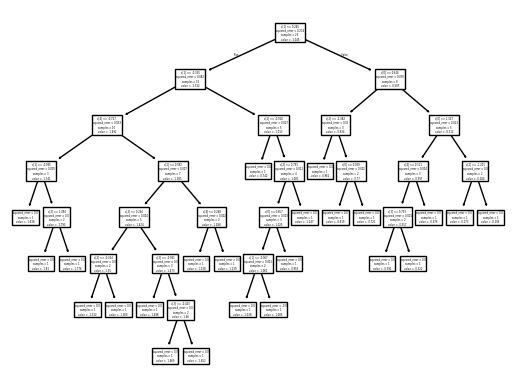

In [14]:
regressor = tree.DecisionTreeRegressor(random_state=42)
regressor.fit(Xt, Yt)
tree.plot_tree(regressor)


In [15]:
y_pred_t = regressor.predict(Xt)
y_pred_v = regressor.predict(Xv)
R2 = r2_score(y_pred_t, Yt)
RMSEc = root_mean_squared_error(y_pred_t, Yt)
Q2ext = r2_score(y_pred_v, Yv)
RMSEext = root_mean_squared_error(y_pred_v, Yv)
print(f'R2 = {R2}\nRMSEc = {RMSEc}\nQ2ext = {Q2ext}\nRMSEext = {RMSEext}')

R2 = 1.0
RMSEc = 0.0
Q2ext = 0.82441841908688
RMSEext = 0.1691624465811881


In [16]:
y_pred_t = regressor.predict(Xt)
y_pred_v = regressor.predict(Xv)
R2 = r2_score(Yt, y_pred_t)
RMSEc = np.sqrt(mean_squared_error(Yt, y_pred_t))
Q2ext = r2_score(Yv, y_pred_v)
RMSEext = np.sqrt(mean_squared_error(Yv, y_pred_v))
print(f'R2 = {R2}\nRMSEc = {RMSEc}\nQ2ext = {Q2ext}\nRMSEext = {RMSEext}')

R2 = 1.0
RMSEc = 0.0
Q2ext = 0.8320435446458981
RMSEext = 0.1691624465811881


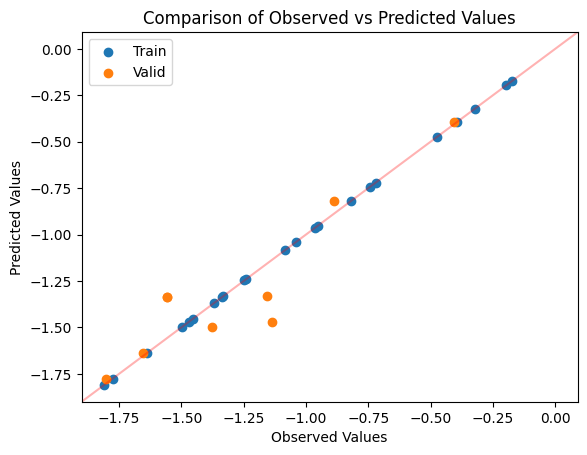

In [17]:
plt.scatter(Yt, y_pred_t, label=f'Train')
plt.scatter(Yv, y_pred_v, label=f'Valid')

# Add legend
plt.legend()

# Add a diagonal line for reference
plt.axline((0, 0), slope=1, color="red", alpha=0.3)

# Add title and labels
plt.title("Comparison of Observed vs Predicted Values")
plt.xlabel("Observed Values")
plt.ylabel("Predicted Values")

# Show plot
plt.show()

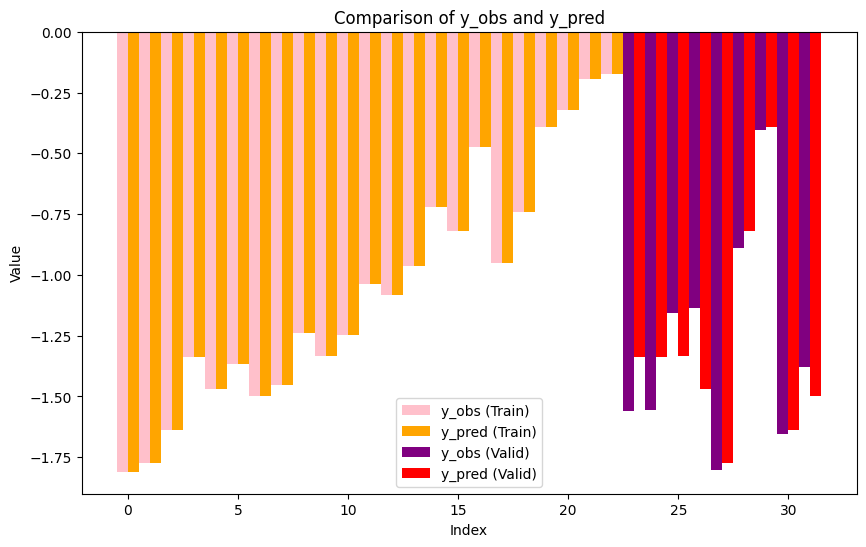

In [18]:
# Convert y_pred and y_obs to 1D arrays for easier plotting
y_pred_training_flat = y_pred_t.flatten()
y_obs_training_flat = Yt.squeeze().to_numpy()
y_pred_test_flat = y_pred_v.flatten()
y_obs_test_flat = Yv.squeeze().to_numpy()

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.5  # the width of the bars

# Plot y_obs and y_pred for training data side by side
ax.bar(np.arange(len(y_obs_training_flat)) - width/2, y_obs_training_flat, width, label='y_obs (Train)', color='pink')
ax.bar(np.arange(len(y_obs_training_flat)) + width/2, y_pred_training_flat, width, label='y_pred (Train)', color='orange')

# Plot y_obs and y_pred for test data side by side
ax.bar(np.arange(len(y_obs_training_flat), len(y_obs_training_flat) + len(y_obs_test_flat)) - width/2, y_obs_test_flat, width, label='y_obs (Valid)', color='purple')
ax.bar(np.arange(len(y_obs_training_flat), len(y_obs_training_flat) + len(y_obs_test_flat)) + width/2, y_pred_test_flat, width, label='y_pred (Valid)', color='red')

# Add labels and legend
ax.set_xlabel('Index')
ax.set_ylabel('Value')
ax.set_title('Comparison of y_obs and y_pred')
ax.legend()

plt.show()

In [19]:
# Definiowanie przestrzeni hiperparametrów do optymalizacji
param_space = {
    'max_depth': (1, 10),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
    'max_features': (1, 10)
}

# Inicjalizacja optymalizacji Bayesowskiej
bayes_search = BayesSearchCV(
    estimator=regressor,
    search_spaces=param_space,
    n_iter=32,  # Liczba iteracji
    cv=5,       # Liczba podziałów w walidacji krzyżowej
    n_jobs=-1,  # Użycie wszystkich dostępnych rdzeni CPU
    random_state=42
)

# Przeprowadzenie optymalizacji
bayes_search.fit(Xt, Yt)

# Wyniki
print("Najlepsze parametry (Bayes Search):", bayes_search.best_params_)
print("Najlepszy wynik (Bayes Search):", bayes_search.best_score_)

Najlepsze parametry (Bayes Search): OrderedDict({'max_depth': 5, 'max_features': 9, 'min_samples_leaf': 3, 'min_samples_split': 5})
Najlepszy wynik (Bayes Search): -8.734251754395032


In [21]:
# Definiowanie przestrzeni hiperparametrów do optymalizacji
param_dist = {
    'max_depth': np.arange(1, 11),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
    'max_features': np.arange(1, 11)
}

# Inicjalizacja Random Search
random_search = RandomizedSearchCV(
    estimator=regressor,
    param_distributions=param_dist,
    n_iter=32,  # Liczba iteracji
    cv=5,       # Liczba podziałów w walidacji krzyżowej
    n_jobs=-1,  # Użycie wszystkich dostępnych rdzeni CPU
    random_state=42
)

# Przeprowadzenie optymalizacji
random_search.fit(Xt, Yt)

# Wyniki
print("Najlepsze parametry (Random Search):", random_search.best_params_)
print("Najlepszy wynik (Random Search):", random_search.best_score_)

Najlepsze parametry (Random Search): {'min_samples_split': np.int64(8), 'min_samples_leaf': np.int64(4), 'max_features': np.int64(3), 'max_depth': np.int64(5)}
Najlepszy wynik (Random Search): -11.606109637729357


In [23]:
# Ocena modelu z optymalizacją Bayesowską
best_model_bayes = bayes_search.best_estimator_
y_pred_bayes = best_model_bayes.predict(Xt)
mse_bayes = mean_squared_error(Yt, y_pred_bayes)
print("MSE (Bayes Search):", mse_bayes)

# Ocena modelu z Random Search
best_model_random = random_search.best_estimator_
y_pred_random = best_model_random.predict(Xt)
mse_random = mean_squared_error(Yt, y_pred_random)
print("MSE (Random Search):", mse_random)

MSE (Bayes Search): 0.012620918202898554
MSE (Random Search): 0.017088424927536233


In [ ]:
print('Bayes Search')
R2 = r2_score(Yt, y_pred_bayes)
RMSEc = np.sqrt(mean_squared_error(Yt, y_pred_bayes))
y_pred_bayes_v = best_model_bayes.predict(Xv)
Q2ext = r2_score(Yv, y_pred_bayes_v)
RMSEext = np.sqrt(mean_squared_error(Yv, y_pred_bayes_v))
print(f'R2 = {R2}\nRMSEc = {RMSEc}\nQ2ext = {Q2ext}\nRMSEext = {RMSEext}')

Bayes Search
R2 = 0.9461721733176942
RMSEc = 0.1123428600441459
Q2ext = 0.909548110943863
RMSEext = 0.12414076808701707


In [26]:
print('Random Search')
R2 = r2_score(Yt, y_pred_random)
RMSEc = np.sqrt(mean_squared_error(Yt, y_pred_random))
y_pred_random_v = best_model_bayes.predict(Xv)
Q2ext = r2_score(Yv, y_pred_random_v)
RMSEext = np.sqrt(mean_squared_error(Yv, y_pred_random_v))
print(f'R2 = {R2}\nRMSEc = {RMSEc}\nQ2ext = {Q2ext}\nRMSEext = {RMSEext}')

Random Search
R2 = 0.927118394994291
RMSEc = 0.13072270241827252
Q2ext = 0.909548110943863
RMSEext = 0.12414076808701707


Interpretacja wyników:


Użyłam tych samych metod, żeby sprawdzić jak poradzą sobie przy regresji zamiast klasyfikacji. Wychodzi na to, że poradziły sobie lepiej niż brak optymalizacji. Dla metody bez optymalizacji $R^2$ = 1, a $RMSE_c$ = 0. Dla wybranych metod te statystyki są bardzo dobre: dla Bayesa 0.95 oraz 0.11, a dla Random Search 0.92 i 0.13. Outputowe statystyki są lepsze dla metod optymalizacji, ale wynoszą tyle samo tzn., $Q^2_{ext}$ = 0.90, a $RMSE_{ext}$ = 0.12. Są to zadowalające wyniki w porównaniu z brakiem metody dla $Q^2_{ext}$ = 0.83 i $RMSE_{ext}$ = 0.17. Powodem takich samych statystyk dla obu wybranych metod może być to samo wytłumaczenie co w zad 1, a mianowicie, że mała ilość próbek uniemożliwia większą wariancję. Metoda Bayesowska poradziła sobie delikatnie lepiej od Random Search, więc można przypuszczać że wybranie parametrów max_depth: 5, max_features: 9, min_samples_leaf: 3, min_samples_split: 5 może być trochę lepszym wyborem niż max_depth: 5, max_features: 3, min_samples_leaf: 4, min_samples_split: 8.